# PsyNeuLink: Stroop Model
> Colab tip: Open the left sidebar (☰)  -> **Table of Contents** to navigate this notebook.

## Content

- [0. Setup and Installation](#0-Setup-and-Installation)
- [1. Basics](#1-Basics)
- [2. Linear Stroop Model](#2-Linear-Stroop-Model)

## 0. Setup and Installation

Run this once (or whenever you restart the runtime). This will install PsyNeuLink and import it.

In [36]:
try:
    import psyneulink as pnl
    import numpy as np
    print("psyneulink already installed")
except ImportError:
    %pip install psyneulink
    import psyneulink as pnl

psyneulink already installed


## 1. Basics

**Content**

- [Mechanisms](#Mechanisms)
- [Compositions](#Compositions)
- [Show Graph](#Show-Graph)

### Mechanisms

Let's create our first composition in PsyNeuLink that consists of only two mechanisms: `Input` and `Output`. We will give both of them `2` input- and output-ports. For the `Input` we leave `Linear` (the default value) as function, for the `Output`, we will assign a Logistic function. Following machine learning conventions, we will use the term `layer` to refer to these mechanisms.



In [21]:
input_layer = pnl.ProcessingMechanism(name="Input", input_shapes=2)
output_layer = pnl.ProcessingMechanism(name="Output", input_shapes=2, function=pnl.Logistic)

### Compositions

We can now combine these two layers into a `Compositions` object. First, we will define a `pathway` via a list. When we give this pathway to PsyNeuLink it will automatically create a `MappingProjection` between the two layers with reasonable default parameters. In this case, it will create a identity matrix (2x2) wiring the output-port of the `input_layer` to the input-port of the `output_layer`.

In [22]:
in_out_pathway = [input_layer, output_layer]
simple_comp = pnl.Composition(name="simple_comp", pathways=[in_out_pathway]) # Note: pathways expects a list of lists (or pathways

We can execute mechanisms individually by passing an array of the appropriate size:

In [23]:
input_layer.execute([0, 1])

array([[0., 1.]])

We can also execute the entire composition by passing an array to the `run` method:

In [24]:
simple_comp.run([0, 1])

array([[0.5       , 0.73105858]])

or with a list of inputs. The results are stored in the `results` attribute of the compositions.

In [25]:
simple_comp.run([[0, 1], [1, 0], [0.5, 0.5]])
simple_comp.results # Note this also shows the results of the previous run (when running this multiple times the results will be appended)

array([[[0.5       , 0.73105858]],

       [[0.5       , 0.73105858]],

       [[0.73105858, 0.5       ]],

       [[0.62245933, 0.62245933]]])

### Show Graph

A very handy feature of PsyNeuLink is the ability to visualize the composition as a graph:

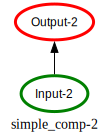

In [26]:
simple_comp.show_graph(output_fmt='jupyter')

The show graph function has many options to customize the output. For example, we can show a more detailed view of the nodes by setting `show_node_structure=True`:

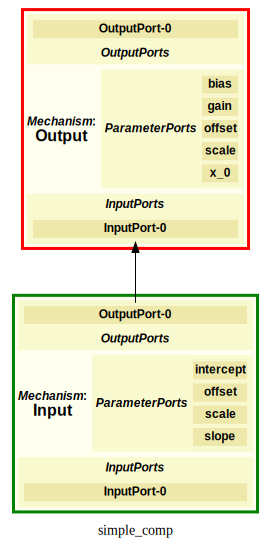

In [16]:
simple_comp.show_graph(output_fmt='jupyter', show_node_structure=True)

### Projections

So far we have only implicitly created a `MappingProjection` by passing a list of mechanisms as a `pathway`. However, if we want more control over the projection, we can create it explicitly. To do so, we define a weight matrix and pass it to the `MappingProjection` constructor. The weight matrix needs to have a shape that is compatible with the output-port of the sender mechanism and the input-port of the receiver mechanism. In this case, both layers have 2 input- and output-ports, so we can use a 2x2 matrix (To make it easier to see, we will use input and output layers with linear identity functions):


In [33]:
input_layer = pnl.ProcessingMechanism(name="Input", input_shapes=2)
output_layer = pnl.ProcessingMechanism(name="Output", input_shapes=2)

# matrix is defined as a list of matrix columns
matrix = [[1, 2],  # weights from input_layer[0] to output_layer[0, 1]
          [3, 4]]  # weights from input_layer[1] to output_layer[0, 1]

projection = pnl.MappingProjection(matrix=matrix)

# Here we show another way of adding a pathway after the composition has been created
simple_comp = pnl.Composition(name="simple_comp")
simple_comp.add_linear_processing_pathway([input_layer, projection, output_layer])

Again, we can run the composition

In [34]:
simple_comp.run([0, 1])

array([[3., 4.]])

In this case, the output can be understood as matrix multiplication between

$$
\begin{bmatrix}
1 & 3 \\
2 & 4
\end{bmatrix}
\cdot
\begin{bmatrix}
0 \\
1
\end{bmatrix}
=
\begin{bmatrix}
3 \\
4
\end{bmatrix}
$$



<details>
<summary>
What is the output of the composition if we run it with input `[1, 1]`?
</summary>
$$
\begin{bmatrix}
1 & 3 \\
2 & 4
\end{bmatrix}
\cdot
\begin{bmatrix}
1 \\
1
\end{bmatrix}
=
\begin{bmatrix}
4 \\
6
\end{bmatrix}
$$
</details>

In [35]:
simple_comp.run([1, 1])

array([[4., 6.]])

## 2. Linear Stroop Model

With the above basics, we can already implement simple models. Here, we will implement a simple version that aims to explain conflict:

![multitasking](https://raw.githubusercontent.com/AutoResearch/ASDMB-Workshop/main/ASDMB-book/_static/img/practical-sessions/spongebob-spongebob-squarepants.gif)

Pat your head and rub your belly at the same time. Unless you have practiced this odd exercise you will get conflict between the motor commands and quickly end up rubbing your head while also rubbing your belly, OR patting your belly while also patting your head. As a more difficult exercise, while sitting, lift your right foot and repeatedly rotate it clockwise while simultaneously tracing a counterclockwise circle in the air with your right hand.

These are examples of **cognitive conflict**. When you are trying to do two things ar once conflict can arise. Other things however, you can do simultaneously without experiencing conflict. For example, you can walk and have a conversation at the same time, or you can eat and watch TV at the same time.

The Stroop Model explains this conflict with shared pathways (or representations). In the classical Stroop Task, the participants are asked to name the color of the ink a word is printed in. The word itself also has the meaning of a color. For example, the word "RED" printed in blue ink. Our model proposes that both recognizing a color and reading a color word share common representations (in our case in the output layer). When the color and meaning match, these representation "work together" and the task is easy. However, when they mismatch, they "work against each other" and cause conflict.

Don't worry if this is not clear yet, it will be once we have implemented the model:


### Task & Model

We will implement a simple version of the Stroop model. The task consists of 2x2 conditions:


- word: RED, GREEN -> one-hot encoded as [1, 0] and [0, 1]
- color: red, green -> one-hot encoded as [1, 0] and [0, 1]

---

- <span style="color:red">RED</span> -> word: [1, 0], color: [1, 0]
- <span style="color:green">RED</span> -> word: [1, 0], color: [0, 1]
- <span style="color:green">GREEN</span> -> word: [0, 1], color: [0, 1]
- <span style="color:red">GREEN</span> -> word: [0, 1], color: [1, 0]

To model the more "automatic" response to word reading, we will give the word input a stronger connection to the output layer then the color input:



In [40]:
# Some CONSTANTS: Strength of processing pathways:
WORD_PROCESSING_STRENGTH = 1.5
COLOR_PROCESSING_STRENGTH = 1

# input layers (shape == 2 for one-hot encoded inputs)
word_input = pnl.ProcessingMechanism(name="Word", input_shapes=2)
color_input = pnl.ProcessingMechanism(name="Color", input_shapes=2)

# output layer (shape == 2 for one-hot encoded output red or green)
response = pnl.ProcessingMechanism(name="Response", input_shapes=2)

# create the compositions
linear_stroop = pnl.Composition(name="Linear Stroop")

# Create the projections
# here we define a simple lateral inhibition matrix (i.e., input to red inhibits green and vice versa)
inhibition_matrix = np.array(
    [[1, -1],
     [-1, 1]])

# scale the inhibition matrix by the processing strength
word_processing_matrix = WORD_PROCESSING_STRENGTH * inhibition_matrix
color_processing_matrix = COLOR_PROCESSING_STRENGTH * inhibition_matrix


# create projections
word_response_projection = pnl.MappingProjection(matrix=word_processing_matrix)
color_response_projection = pnl.MappingProjection(matrix=color_processing_matrix)


# Add pathways to the composition
linear_stroop.add_linear_processing_pathway([
    word_input, word_response_projection, response
])

linear_stroop.add_linear_processing_pathway([color_input, color_response_projection, response])



Let's look at the graph of the model:

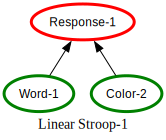

In [41]:
linear_stroop.show_graph(output_fmt='jupyter')

We see, that both color and word input project to the same output layer. Let's see what happens for different inputs. Here, we define the inputs as dictionary with the keys being the input layers:


In [48]:
# Congruent Stimuli
print(f'{"*"*10}Congruent Stimuli{"*"*10}')
# RED written in red:
rr = {word_input: [1, 0], color_input: [1, 0]}
response_r, response_g = linear_stroop.run(rr)[0]
print('Red written in red:\n',
      f'Red response activation: {response_r}\n'
      f'Green response activation: {response_g}\n')

# GREEN written in green:
gg = {word_input: [0, 1], color_input: [0, 1]}
response_r, response_g = linear_stroop.run(gg)[0]
print('Green written in green:\n',
      f'Red response activation: {response_r}\n'
      f'Green response activation: {response_g}\n')

# Incongruent Stimuli
print(f'{"*"*10}Incongruent Stimuli{"*"*10}')
# RED written in green:
rg = {word_input: [1, 0], color_input: [0, 1]}
response_r, response_g = linear_stroop.run(rg)[0]
print('RED written in green:\n',
      f'Red response activation: {response_r}\n'
      f'Green response activation: {response_g}\n')

# green written in red:
gr = {word_input: [0, 1], color_input: [1, 0]}
response_r, response_g = linear_stroop.run(gr)[0]
print('GREEN written in red:\n',
      f'Red response activation: {response_r}\n'
      f'Green response activation: {response_g}\n')

# green written in green:
print('Green written in Green:', linear_stroop.run(gg))

**********Congruent Stimuli**********
Red written in red:
 Red response activation: 2.5
Green response activation: -2.5

Green written in green:
 Red response activation: -2.5
Green response activation: 2.5

**********Incongruent Stimuli**********
RED written in green:
 Red response activation: 0.5
Green response activation: -0.5

GREEN written in red:
 Red response activation: -0.5
Green response activation: 0.5

Green written in Green: [[-2.5  2.5]]


The above model can explain "congruency" effects. When the color and word match (congruent stimuli) the difference between the two output units is larger than when they mismatch (incongruent stimuli).

### Adding A Drift Diffusion Module

The numbers are hard to interpret, and we would like to add some stochasticity: "It is more likely to be wrong on incongruent trials, and it is slower". To model this, we can add a Drift Diffusion Module to the response:

![multitasking](https://raw.githubusercontent.com/AutoResearch/ASDMB-Workshop/main/ASDMB-book/_static/img/practical-sessions/ddm.png)